In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

Data preprocessing from Tensorflow: https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [2]:
# for colab
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/Colab Notebooks/IDL2019/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [7]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang) #Create vocabulary

  tensor = lang_tokenizer.texts_to_sequences(lang) #convert text to sequences
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
print(input_tensor.shape)
print(target_tensor.shape)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(30000, 16)
(30000, 11)


(11, 16)

In [11]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [12]:
input_tensor_train.shape #24000 sentences with less that 16 words per sentence

(24000, 16)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
807 ----> levanta
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
64 ----> get
50 ----> up
3 ----> .
2 ----> <end>


In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
print("Input vocab = ",vocab_inp_size)
print("Target vocab = ",vocab_tar_size)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()


Input vocab =  9414
Target vocab =  4935


In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 16]), TensorShape([128, 11]))

In [0]:
optimizer = tf.keras.optimizers.Adam()
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
#     from_logits=True, reduction='none')
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # print(real.shape)
  # print(pred.shape)

  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
# model(encoder)
n_h = 1024
w_xh = tf.Variable(tf.initializers.glorot_uniform()([vocab_inp_size, n_h]))
w_hh = tf.Variable(tf.initializers.glorot_uniform()([n_h, n_h]))
b_h = tf.Variable(tf.zeros([n_h]))

w_ho = tf.Variable(tf.initializers.glorot_uniform()([n_h, vocab_inp_size]))
b_o = tf.Variable(tf.zeros([vocab_inp_size]))


# model(decoder)
d_n_h = 1024
d_w_xh = tf.Variable(tf.initializers.glorot_uniform()([vocab_tar_size + d_n_h, d_n_h]))
d_w_hh = tf.Variable(tf.initializers.glorot_uniform()([d_n_h, d_n_h]))
d_b_h = tf.Variable(tf.zeros([d_n_h]))

d_w_ho = tf.Variable(tf.initializers.glorot_uniform()([d_n_h, vocab_tar_size + d_n_h]))
d_b_o = tf.Variable(tf.zeros([vocab_tar_size + d_n_h]))

all_vars = [w_xh, w_hh, b_h, w_ho, b_o, d_w_xh, d_w_hh, d_b_h, d_w_ho, d_b_o]


In [0]:
# training
# somewhat arbitrary number of steps
steps = 24000 * 100 // BATCH_SIZE
opt = tf.optimizers.Adam()
# loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)


# @tf.function
def run_rnn_on_seq(inp_batch, target_batch):
    loss = 0.

    with tf.GradientTape() as tape:
        encoder_output = tf.Variable(tf.zeros([tf.shape(inp_batch)[0],max_length_inp,vocab_inp_size]), dtype= tf.float32)#(128,16,9414)
        encoder_States = tf.Variable(tf.zeros([tf.shape(inp_batch)[0],max_length_inp,n_h]), dtype= tf.float32)#(128,16,512)

        # print("encoder_output")
        # print(encoder_output.shape) #(128,16,9414)

        state = tf.Variable(tf.zeros([tf.shape(inp_batch)[0], n_h]), dtype= tf.float32)
        decoder_state = tf.Variable(tf.zeros([tf.shape(target_batch)[0], d_n_h]), dtype= tf.float32)

        # print(state)#(128, 512)
        total_loss = tf.constant(0.)
        for time_step in tf.range(tf.shape(inp_batch)[1]): #sequence size = 16(loop runs 16 times)
            inp_here = tf.one_hot(inp_batch[:, time_step], vocab_inp_size)
            # print(inp_here.shape)#(128,9414)

            state = tf.nn.tanh(tf.matmul(inp_here, w_xh) + tf.matmul(state, w_hh) + b_h)
            encoderlogits = tf.matmul(state, w_ho) + b_o
            # print("encoderlogits")
            # print(encoderlogits.shape)#(128,9414)
            encoder_output = encoder_output[:, time_step].assign(encoderlogits)
            encoder_States = encoder_States[:, time_step].assign(state)
            # decoder_state = state

        # print(encoder_output.shape)#(128,16,9414)
        # print(encoder_States.shape)#(128,16,512)
        alpha = tf.Variable(tf.zeros([tf.shape(inp_batch)[0], max_length_inp]))
      
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 0)[0]
        # print(dec_input.shape)#(128, )
        for time_step in tf.range(tf.shape(target_batch)[1]): #target sequence size = 11(loop runs 11 times)
            
            for i in tf.range(tf.shape(inp_batch)[1]):
              score = tf.multiply(encoder_States[:, i],decoder_state)#(128,512)*(512,128)
              # print(score.shape)#(128,512)
              score = tf.math.reduce_sum(score,1) #WHY IS THIS DONE?
              # print(score.shape)#(128,)
              alpha = alpha[:, i].assign(score) #(128,) repeated 16 times

            attention_weights = tf.nn.softmax(alpha, axis = 1)
            # print(attention_weights.shape)#(128,16)
            attention_weights = tf.expand_dims(attention_weights, 2) #WHY IS THIS DONE?
            # print(attention_weights.shape)#(128,16,1)

            context_vector = attention_weights * encoder_States
            context_vector = tf.reduce_sum(context_vector, axis=1)
            # print(context_vector.shape)#(128,512)
            # print(dec_input.shape)#(1)

            # dec_input = tf.concat([tf.expand_dims(context_vector, 1), dec_input], axis=-1)
            inp_here = tf.one_hot(dec_input, vocab_tar_size)
            inp_here = tf.concat([context_vector, inp_here], axis=1)
            # print(inp_here.shape)#(128, 5447)
            
            decoder_state = tf.nn.tanh(tf.matmul(inp_here, d_w_xh) + tf.matmul(decoder_state, d_w_hh) + d_b_h)

            logits = tf.matmul(decoder_state, d_w_ho) + d_b_o
            # print(logits.shape)
            # print(target_batch[:, time_step].shape)

            loss += loss_function(target_batch[:, time_step], logits)

            # using teacher forcing
            # dec_input =  tf.expand_dims(target_batch[:, time_step])
            dec_input = target_batch[:, time_step]

                
        batch_loss = loss /tf.cast(tf.shape(target_batch)[1] - 1, tf.float32)

    grads = tape.gradient(batch_loss, all_vars)
    # this is gradient clipping
    # glob_norm = tf.linalg.global_norm(grads)
    # grads = [g/glob_norm for g in grads]
    
    optimizer.apply_gradients(zip(grads, all_vars))    
    return batch_loss


In [0]:
def evaluate(sentence):
   sentence = preprocess_sentence(sentence)
   attention_plot = np.zeros((max_length_targ, max_length_inp))

   inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
   inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
   inp_batch = tf.convert_to_tensor(inputs)

   state = tf.Variable(tf.zeros([tf.shape(inp_batch)[0], n_h]), dtype= tf.float32)
   decoder_state = tf.zeros([1, d_n_h])
   encoder_output = tf.Variable(tf.zeros([tf.shape(inp_batch)[0],max_length_inp,vocab_inp_size]), dtype= tf.float32)#(128,16,9414)
   encoder_States = tf.Variable(tf.zeros([tf.shape(inp_batch)[0],max_length_inp,n_h]), dtype= tf.float32)#(128,16,512)

   for time_step in tf.range(tf.shape(inp_batch)[1]): #sequence size = 16(loop runs 16 times)
      inp_here = tf.one_hot(inp_batch[:, time_step], vocab_inp_size)

      state = tf.nn.tanh(tf.matmul(inp_here, w_xh) + tf.matmul(state, w_hh) + b_h)
      encoderlogits = tf.matmul(state, w_ho) + b_o

      encoder_output = encoder_output[:, time_step].assign(encoderlogits)
      encoder_States = encoder_States[:, time_step].assign(state)
          
   alpha = tf.Variable(tf.zeros([tf.shape(inp_batch)[0], max_length_inp]))
   translation = [targ_lang.word_index['<start>']]
   dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)[0]
   for time_step in tf.range(max_length_targ): #target sequence size = 11(loop runs 11 times)
            
        for i in tf.range(tf.shape(inp_batch)[1]):
            score = tf.multiply(encoder_States[:, i],decoder_state)#(128,512)*(512,128)
            score = tf.math.reduce_sum(score,1) #WHY IS THIS DONE?
            alpha = alpha[:, i].assign(score) #(128,) repeated 16 times

        attention_weights = tf.nn.softmax(alpha, axis = 1)
        attention_weights = tf.expand_dims(attention_weights, 2) #WHY IS THIS DONE?

        context_vector = attention_weights * encoder_States
        context_vector = tf.reduce_sum(context_vector, axis=1)

        inp_here = tf.one_hot(dec_input, vocab_tar_size)
        inp_here = tf.concat([context_vector, inp_here], axis=1)
            
        decoder_state = tf.nn.tanh(tf.matmul(inp_here, d_w_xh) + tf.matmul(decoder_state, d_w_hh) + d_b_h)
        logits = tf.matmul(decoder_state, d_w_ho) + d_b_o
           
        predicted_id =tf.argmax(logits[0]).numpy()
       
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[time_step] = attention_weights.numpy()
        
        translation.append(predicted_id)

        if predicted_id == targ_lang.word_index['<end>']:
           result =  "".join([targ_lang.index_word[ind] + " " for ind in translation[2:]])
           return result, sentence,attention_plot 
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)[0]
      
   result =  "".join([targ_lang.index_word[ind] + " " for ind in translation[2:]])

   return result, sentence, attention_plot

In [0]:
def translate(sentence, skip):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  
  if not skip:
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [26]:
for step, seqs in enumerate(dataset):
    inp = seqs[0]
    tar = seqs[1]
    # print(inp.shape)#(128, 16)
    # print(tar.shape)#(128, 11)

    xent_avg = run_rnn_on_seq(inp, tar)

    if not step % 200:
        print("Step: {} Loss: {}".format(step, xent_avg))
        translate('hace mucho frio aqui.', True)
        #Input: <start> hace mucho frio aqui . <end>
        #Actual translation: it s very cold here . <end>

        translate('esta es mi vida.', True)
        #Actual translation: this is my life . <end> 
        
        translate('¿todavia estan en casa?', True)
        #Actual translation: are you still home ? <end> 

        translate('trata de averiguarlo.', True)
        #Actual translation: try to figure it . <end> 
        print("===============================================")
        
    if step > steps:
        break

Step: 0 Loss: 2.502750873565674
Input: <start> hace mucho frio aqui . <end>
Predicted translation: i s the . 
Input: <start> esta es mi vida . <end>
Predicted translation: i s the . 
Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: i is the . . 
Input: <start> trata de averiguarlo . <end>
Predicted translation: i s a . 
Step: 200 Loss: 1.9871532917022705
Input: <start> hace mucho frio aqui . <end>
Predicted translation: tom is a . 
Input: <start> esta es mi vida . <end>
Predicted translation: tom is a . 
Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: what is a a ? 
Input: <start> trata de averiguarlo . <end>
Predicted translation: i m a . 
Step: 400 Loss: 1.711618423461914
Input: <start> hace mucho frio aqui . <end>
Predicted translation: tom has a lot . 
Input: <start> esta es mi vida . <end>
Predicted translation: the is is good . 
Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: what s your house ? 
Input: <start> trat

KeyboardInterrupt: ignored

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


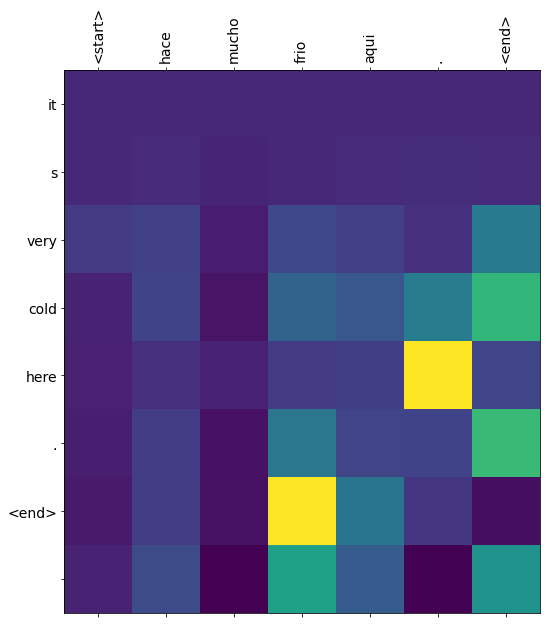

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


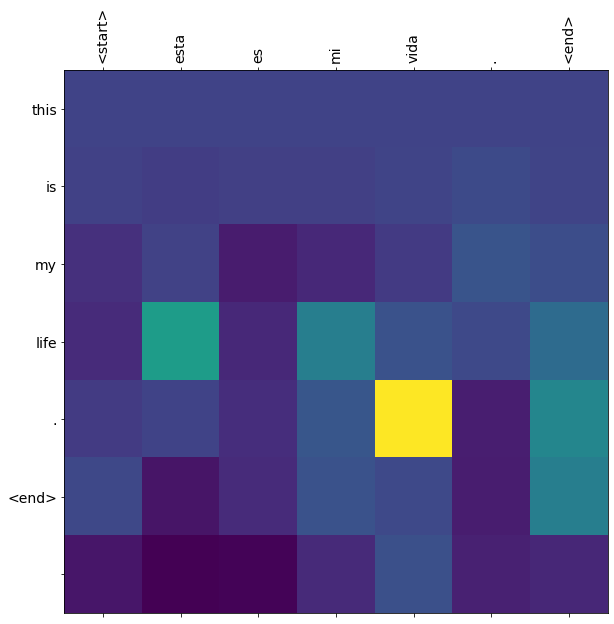

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


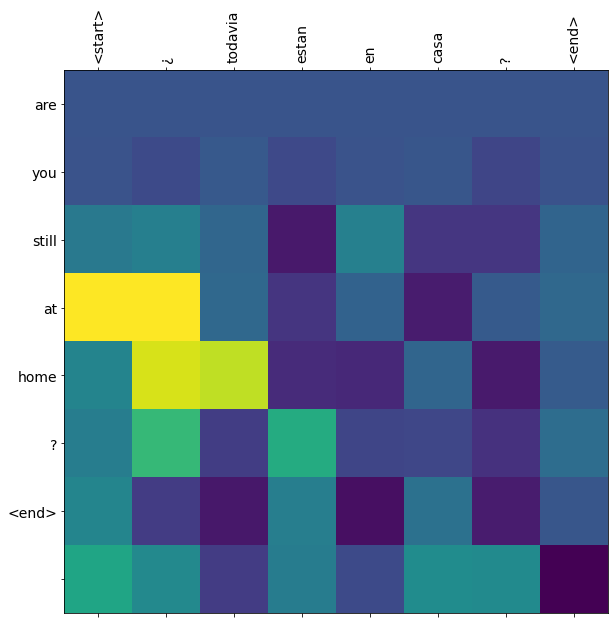

Input: <start> trata de averiguarlo . <end>
Predicted translation: it s gone . <end> 


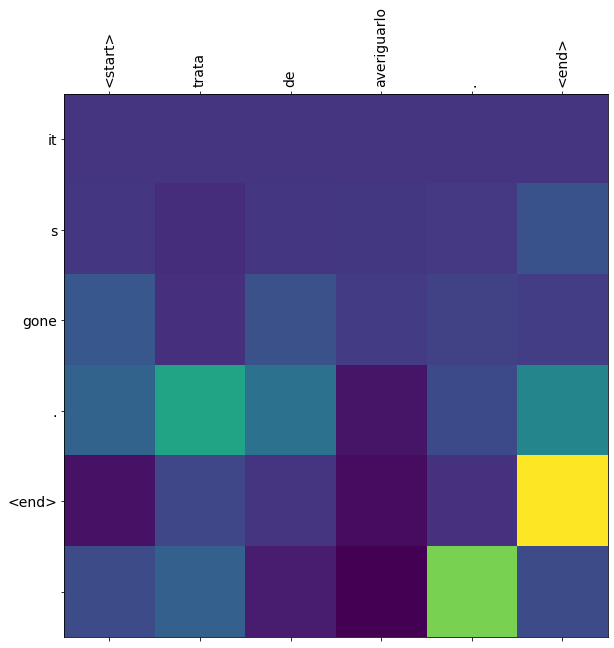

In [30]:
translate('hace mucho frio aqui.', False)
        #Input: <start> hace mucho frio aqui . <end>
        #Actual translation: it s very cold here . <end>
translate('esta es mi vida.', False)
        #Actual translation: this is my life . <end> 
        
translate('¿todavia estan en casa?', False)
        #Actual translation: are you still home ? <end> 

translate('trata de averiguarlo.', False)
        #Actual translation: try to figure it . <end> 